# Arthur Sandbox Example: Credit Card Default 

In this guide, we'll use a tabular dataset and pre-computed predictions to onboard a new streaming model to the Arthur platform. Then we will use Arthur to analyze our model.


# Outline

Read on for an overview of everything this notebook will cover. **[Click here to dive straight into the code.](#Imports)**

## Onboarding

Onboarding is the process of setting up your model to be monitored by Arthur. You specify the type of data your model ingests, send a reference dataset to provide a baseline of the distribution of your data, and you configure additional settings among the services Arthur offers.

**Arthur does not need your model object itself to monitor performance - only predictions are required**

All you need to monitor your model with Arthur is to upload the predictions your model makes: Arthur computes analytics about your model based on that prediction data. This data can be computed directly by your model in a script or notebook like this one to be uploaded to the platform, or can be fetched from an external database to be sent to Arthur.

You may optionally provide your model itself to enable Explainability, which shows the features driving your model's decision-making, and What-If, which lets you see how your model would respond to feature adjustments through the Arthur Dashboard or API.

### Getting Model Predictions
We'll prepare a reference dataset of a sample of training data and predictions from a pre-trained model.

### Registering Model with Arthur
We'll build our model on the reference dataset, configure our model attributes, save the model to the Arthur platform, and activate explainability.

### Sending Inferences
We'll send model inferences (inputs and predictions) to the Arthur platform, and then send the corresponding ground truth values (which are matched to the predictions by inference IDs).

### (Optional) Activating Enrichments
We'll activate model enrichments, which are additional services Arthur provides with automated backend computation to make model monitoring and analysis easier for Arthur users:

|  |  |
| ---------- | ----------- |
| **Anomaly Detection** | Anomaly scores for individual inferences help identify outliers in a model's data pipeline. |
| **Explainability** | Model explanations estimate the relative impact of different input features on inferences.|
| **Hotspots** | Hotspots are regions of data where Arthur automatically identifies low performance metrics.|
| **Bias Mitigation** | Bias mitigation post-processes model outputs to balance performance with groupwise fairness. |

## Model Monitoring and Analysis

Once onboarding is complete and you have inferences uploaded to the platform, you can use Arthur to get model monitoring insights.

### Performance
We'll get accuracy, F1, and AUC performance metrics for our model.

### Drift
We'll get KL divergence metrics for our model, which measures how far our model's attributes have strayed from their baseline distribution.

### Bias Monitoring
We'll compare model metrics split by sensitive attributes in order to proactively understand how a model is underperforming on different groups in its dataset.

### Alerts
We'll configure model alerts, which send messages notifying of recent changes in model performance.

### Enrichments
We'll get extra insights on model performance with anomaly detection, model explanations, performance hotspots, and bias mitigation post-processing analysis.

---

# Setup & Imports

In [52]:
# ensure required packages are installed
#  don't worry, our requirements are flexible!

! pip install -r requirements.txt > /dev/null

In [1]:
from datetime import datetime, timedelta
from IPython.display import display, HTML
import numpy as np
import pandas as pd

import arthurai
from arthurai import ArthurAI
from arthurai.common.constants import InputType, OutputType, Stage, Enrichment
from arthurai.util import generate_timestamps

from utils.arthur_example import get_arthur_example

---

# Onboarding

## Loading the Data

We'll load data split into "train" and "inference" sets. We'll use the training data as our baseline reference dataset, and later on we'll use the inference set to mimic production inferences our model would be making.

Note that we load predictions from a pre-trained model as well. You might imagine fetching these predictions from a historical database if you have them saved, or running your model locally to re-compute them on the training and inference data.

### The Dataset

We're using the Credit Default dataset, which examines the likelihood of individuals defaulting on a credit card. This dataset is stored on the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients), and was compiled by researchers from Chung Hua University and Tamkang University in Taiwan. 

- Each row in the dataset represents a bank customer. 
- The first feature is `LIMIT_BAL`, which shows the amount of credit available to the customer for a given month.
- The next seven features, `PAY_0`...`PAY_6` indicate the status of the customer's history of past payment, with negative values indicating complete payments and positive values indicating the delay in months of payment.
- The next six features, `BILL_AMT1`...`BILL_AMT6` represent the amount the customer currently owes each month to the bank from the previous 6 months.
- The final six features, `PAY_AMT1`...`PAY_AMT6` represent the amount the customer paid to the bank each month from the previous 6 months.

We split out sensitive features for the data that the model does not process. We will still track this data as sensitive attributes in our ArthurModel so that we can proactively monitor our model for bias against these attributes, even though the model does not directly use them as features.

In [2]:
credit_card_default_example = get_arthur_example('credit_card_default_drifty')
X_train, X_inf = credit_card_default_example.get_inputs(split=True)
X_train.head()

,LIMIT_BAL,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
14855,40000,0,0,0,0,0,0,36159,38241,39121,40400,40000,40000,3000,1800,2000,0,0,0
23582,80000,1,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0
331,90000,-1,-1,-1,-1,-1,-1,3000,6000,0,3000,3000,3000,6000,0,3000,3000,3000,3000
25642,50000,0,0,0,0,0,2,45675,41712,29756,32418,34983,18175,3630,2000,3500,2713,0,193
29466,180000,1,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,800


In [3]:
y_train, y_inf = credit_card_default_example.get_labels(split=True)
y_train.head()

,ground_truth_credit_default
14855,0
23582,1
331,0
25642,0
29466,1


In [4]:
sens_data_train, sens_data_inf = credit_card_default_example.get_sensitive_data(split=True)
sens_data_train.head()

,SEX,AGE,EDUCATION,MARRIAGE
14855,2,49,2,1
23582,1,26,1,2
331,2,33,1,2
25642,2,22,2,2
29466,2,32,2,1


In [5]:
preds_train, preds_inf = credit_card_default_example.get_predictions(split=True)
preds_train.head()

,pred_proba_credit_default
14855,0.00000
23582,0.24958
331,0.10000
25642,0.10000
29466,0.90000


### Preparing `reference_data`

A reference dataset is an example of what you expect data to look like during deployment. When your model ingests data during deployment, drift metrics and anomaly scores are computed by comparing new inferences against the reference set.

We include the model's training data features in our reference dataset, as well as predicted model probabilities, sensitive attributes, and ground truth labels for these inferences.

**Only model input attributes are required during onboarding, but others are recommended**: 

Including predicted model output values, sensitive attributes, and ground truth labels when onboarding to Arthur is **optional**. Including these attributes during onboarding, if they are available, is recommended because it can be used to track drift and evaluate future model performance against baseline model performance.

Read more about [reference datasets in our documentation](https://docs.arthur.ai/user-guide/basic_concepts.html#reference-dataset).

In [6]:
# reference_data will contain the model's input features, 
# predicted probabilities, ground truth labels, and sensitive attributes,
reference_data = pd.concat([
    X_train,
    preds_train,
    y_train,
    sens_data_train
], axis=1)

                           
reference_data.head()

,LIMIT_BAL,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,...,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,pred_proba_credit_default,ground_truth_credit_default,SEX,AGE,EDUCATION,MARRIAGE
14855,40000,0,0,0,0,0,0,36159,38241,39121,...,2000,0,0,0,0.00000,0,2,49,2,1
23582,80000,1,-2,-2,-2,-2,-2,0,0,0,...,0,0,0,0,0.24958,1,1,26,1,2
331,90000,-1,-1,-1,-1,-1,-1,3000,6000,0,...,3000,3000,3000,3000,0.10000,0,2,33,1,2
25642,50000,0,0,0,0,0,2,45675,41712,29756,...,3500,2713,0,193,0.10000,0,2,22,2,2
29466,180000,1,-2,-2,-2,-2,-2,0,0,0,...,0,0,0,800,0.90000,1,2,32,2,1


## Registering Model With Arthur

### Setting Up Connection
Supply your login to authenticate with the platform.

In [ ]:
# connect to Arthur
# UNCOMMENT the two lines below and enter your details
arthur = ArthurAI(
    # url="https://beta.app.arthur.ai",  # you can also pass this through the ARTHUR_ENDPOINT_URL environment variable
    # login="<YOUR_USERNAME_OR_EMAIL>",  # you can also pass this through the ARTHUR_LOGIN environment variable
)

### Registering Model Type

We'll instantiate an [`ArthurModel`](https://docs.arthur.ai/sdk/sdk_v3/apiref/arthurai.core.models.ArthurModel.html) with the `ArthurAI.model()` method, which constructs a new local `ArthurModel` object. Later we'll use `ArthurModel.save()` to register this model with the Arthur platform.

We give the model a user-friendly `display_name` and allow the unique `partner_model_id` field to be automatically generated, but you can supply a unique identifier if it helps you map your models in Arthur to your other MLOps systems.

The `InputType` of a model specifies the general type of data your model ingests. The `OutputType` of a model specifies the modeling task at hand.

In [9]:
# instantiate an ArthurModel object to be registered 
# with the Arthur platform with a name and a type
arthur_model = arthur.model(
    display_name="Example: Credit Default",
    # partner_model_id="optional-unique-identifier",
    input_type=InputType.Tabular,
    output_type=OutputType.Multiclass)

We have just registered a streaming model, which is the default for an ArthurModel. A streaming model receives instances of data as they come into the deployed model. A batch model, in contrast, receives data in groups, and is often preferred if your model runs as a job rather than operating in realtime or over a data stream. To indicated a batch model, simply add an `is_batch=True` parameter to the call above.

You can read more about [streaming and batch models in our documentation](https://docs.arthur.ai/user-guide/basic_concepts.html#basic-concepts-streaming-vs-batch).

### Building the Model Schema on the Reference Dataset

We'll use the `reference_data` prepared above to register the model schema for this tabular classifier model. The model schema is a record of the names, shapes, datatypes, and other properties for the attributes data your model uses (inputs, outputs, ground truth values, and other non-input attributes). 

We'll do this with the [ArthurModel.build()](https://docs.arthur.ai/sdk/sdk_v3/apiref/arthurai.core.models.ArthurModel.html#arthurai.core.models.ArthurModel.build) method, which configures our model using the provided reference dataframe and a map that defines how predicted probabilities correspond to ground truth values.

In [10]:
# Map PredictedValue attribute to its corresponding GroundTruth attribute value.
# This tells Arthur that the `pred_proba_credit_default` column represents 
# the probability that the ground truth column has the value 1
pred_to_ground_truth_map = {'pred_proba_credit_default' : 1}

# Build arthur_model schema on the reference dataset,
# specifying which attribute represents ground truth
# and which attributes are NonInputData.
# Arthur will monitor NonInputData attributes 
# even though they are not model inputs.
arthur_model.build(
    reference_data, 
    ground_truth_column='ground_truth_credit_default',
    pred_to_ground_truth_map=pred_to_ground_truth_map,
    non_input_columns=sens_data_train.columns
)

2023-01-28 16:10:55,643 - arthurai.core.models - WARNING - Found one or more categorical attributes. It is suggested to use model.review() to verify all possible categories were inferred correctly for each categorical attribute. To update with new categories, use model.get_attribute(attr_name).set(categories=[cat_1, cat_2, cat_3])
2023-01-28 16:10:55,648 - arthurai.core.models - WARNING - Found one or more categorical attributes. It is suggested to use model.review() to verify all possible categories were inferred correctly for each categorical attribute. To update with new categories, use model.get_attribute(attr_name).set(categories=[cat_1, cat_2, cat_3])


16:10:55 - arthurai - Please review the inferred schema. If everything looks correct, lock in your model by calling arthur_model.save()


,name,stage,value_type,categorical,is_unique,categories,bins,range,monitor_for_bias
0,LIMIT_BAL,PIPELINE_INPUT,INTEGER,False,False,[],None,"[10000, 1000000]",False
1,PAY_0,PIPELINE_INPUT,INTEGER,True,False,"[{value: 0}, {value: 1}, {value: 2}, {value: 3...",None,"[None, None]",False
2,PAY_2,PIPELINE_INPUT,INTEGER,True,False,"[{value: 0}, {value: 1}, {value: 2}, {value: 3...",None,"[None, None]",False
3,PAY_3,PIPELINE_INPUT,INTEGER,True,False,"[{value: 0}, {value: 1}, {value: 2}, {value: 3...",None,"[None, None]",False
4,PAY_4,PIPELINE_INPUT,INTEGER,True,False,"[{value: 0}, {value: 2}, {value: 3}, {value: 4...",None,"[None, None]",False
5,PAY_5,PIPELINE_INPUT,INTEGER,True,False,"[{value: 0}, {value: 2}, {value: 3}, {value: 4...",None,"[None, None]",False
6,PAY_6,PIPELINE_INPUT,INTEGER,True,False,"[{value: 0}, {value: 2}, {value: 3}, {value: 4...",None,"[None, None]",False
7,BILL_AMT1,PIPELINE_INPUT,INTEGER,False,False,[],None,"[-14386, 964511]",False
8,BILL_AMT2,PIPELINE_INPUT,INTEGER,False,False,[],None,"[-69777, 983931]",False
9,BILL_AMT3,PIPELINE_INPUT,INTEGER,False,False,[],None,"[-61506, 565550]",False


### Configuring Attributes

#### Monitoring Sensitive Attributes for Bias

We will specify that a few attributes (`SEX`, `AGE`, and `EDUCATION`) should be [monitored for bias](https://docs.arthur.ai/user-guide/walkthroughs/bias_monitoring.html).

In [11]:
# monitoring attributes for bias
for attr in sens_data_train.columns:
    arthur_model.set_attribute_as_sensitive(attr)

#### Binning Continuous Attributes

Binning an attribute means placing a continuous value into one of a set of buckets. For example, one might bin an age attribute into an `old` bucket and a `young` bucket, using the bins `[None, 65, None]` to set the binned age value to be `young` when `age <= 65`, and the binned age value to be `old` when `age > 65`.

The `bins` property of an attribute are used for two tasks in the Arthur system:

1: Determining default settings for filters and attribute groupings in the online dashboard

2: Determining the groups with which to measure bias. For example, monitoring the `age` attribute with the bins set above would monitor whether a model was biased towards people over/under age 65.

Note that this property does not impact other metrics - for example, different bins are chosen when calculating drift, so the `bins` property of an attribute won't impact drift.

Here we will breakup the continuous `AGE` attribute into discrete bins with the cutoff values 35 and 55. 

In [12]:
# binning a continuous attribute
# this will create 3 bins for the AGE attribute, 
# corresponding to the cutoffs [AGE < 35, 35 < AGE < 55, 55 < AGE]
arthur_model.get_attribute("AGE").set(
    bins = [None, 35, 55, None], 
    categorical=False,
    categories=[], 
)

ArthurAttribute(name='AGE', value_type='INTEGER', stage='NON_INPUT_DATA', id=None, label=None, position=1, categorical=False, min_range=21, max_range=75, monitor_for_bias=True, categories=[], bins=[AttributeBin(continuous_start=None, continuous_end=35), AttributeBin(continuous_start=35, continuous_end=55), AttributeBin(continuous_start=55, continuous_end=None)], is_unique=False, is_positive_predicted_attribute=False, attribute_link=None, gt_class_link=None)

#### Labelling Attributes

We will configure labels for attributes and their values so that the information is more easily readable and understandable in the Arthur dashboard.

In [13]:
# configure attribute labels and attribute value labels
# the labels parameter maps raw attribute values to 
# the labels you would like them to have in the dashboard

arthur_model.set_attribute_labels(
    attribute_name="SEX",
    labels={1: "Male", 2: "Female"})

arthur_model.set_attribute_labels(
    attribute_name="EDUCATION",
    labels={1: "Graduate School", 2: "University",
            3: "High School", 4: "Less Than High School",
            5: "Unknown", 6: "Unreported", 0: "Other"})

arthur_model.set_attribute_labels(
    attribute_name="MARRIAGE",
    labels={1: "Married", 2: "Single",
            3: "Other", 0: "Unknown"})

### Saving the Model

Before saving, be sure to review your model to make sure everything is correct. We already saw the model schema returned by `ArthurModel.build()`, but we have since changed our attribute congiruations. Therefore we call `ArthurModel.review()` to see that our changed attributes look correct before saving to the platform. See the [onboarding walkthrough on the Arthur docs](https://docs.arthur.ai/user-guide/walkthroughs/model-onboarding/index.html#review-model) for tips on reviewing your model.

Note that while we capture the ranges of the attributes in this schema, they don’t need to be exact and won’t affect any performance calculations. They’re used as metadata to configure plots in the online Arthur dashboard, but never affect data drift or any other computations.

In [14]:
# review the model attribute properties in the model schema
arthur_model.review()

,name,stage,value_type,categorical,is_unique,categories,bins,range,monitor_for_bias
0,LIMIT_BAL,PIPELINE_INPUT,INTEGER,False,False,[],None,"[10000, 1000000]",False
1,PAY_0,PIPELINE_INPUT,INTEGER,True,False,"[{value: 0}, {value: 1}, {value: 2}, {value: 3...",None,"[None, None]",False
2,PAY_2,PIPELINE_INPUT,INTEGER,True,False,"[{value: 0}, {value: 1}, {value: 2}, {value: 3...",None,"[None, None]",False
3,PAY_3,PIPELINE_INPUT,INTEGER,True,False,"[{value: 0}, {value: 1}, {value: 2}, {value: 3...",None,"[None, None]",False
4,PAY_4,PIPELINE_INPUT,INTEGER,True,False,"[{value: 0}, {value: 2}, {value: 3}, {value: 4...",None,"[None, None]",False
5,PAY_5,PIPELINE_INPUT,INTEGER,True,False,"[{value: 0}, {value: 2}, {value: 3}, {value: 4...",None,"[None, None]",False
6,PAY_6,PIPELINE_INPUT,INTEGER,True,False,"[{value: 0}, {value: 2}, {value: 3}, {value: 4...",None,"[None, None]",False
7,BILL_AMT1,PIPELINE_INPUT,INTEGER,False,False,[],None,"[-14386, 964511]",False
8,BILL_AMT2,PIPELINE_INPUT,INTEGER,False,False,[],None,"[-69777, 983931]",False
9,BILL_AMT3,PIPELINE_INPUT,INTEGER,False,False,[],None,"[-61506, 565550]",False


Now, we save the model. 

Note that this will be the first call to send data to the Arthur platform so far in this example - no information has been sent yet to the platform.

The method `ArthurModel.save()` sends an API request to Arthur to validate your model - if there are any problems with your model schema, this method will result in an error informing you how to correct your model's configuration. If no errors are found, the model will be saved to the platform, and the reference data we passed to `ArthurModel.build()` will be saved as the model's [reference set](https://docs.arthur.ai/user-guide/basic_concepts.html#reference-dataset), which serves as the default baseline for drift metrics. 

In [15]:
# validate the model and save it onto the Arthur platform
arthur_model.save()

16:11:24 - arthurai - Starting upload (1.141 MB in 1 files), depending on data size this may take a few minutes
16:11:25 - arthurai - Upload completed: /var/folders/fg/t2njc_1s2z3bsbzw5bhn_n0c0000gn/T/tmp8q4fqtct/35212780-2353-4c31-85a2-5fb1afe1a7bf-0.parquet


'35212780-2353-4c31-85a2-5fb1afe1a7bf'

### (Optional) Activating Enrichments

**💡 Enrichments are an advanced feature only available to paid users. For first-time users we recommend [jumping ahead to Sending Inferences](#sending_inferences_content)**.

Enrichments are additional services Arthur provides with automated backend computation to make model monitoring and analysis easier for Arthur users.

Next we will enable the Hotspots & Bias Mitigation enrichments with a single call to `ArthurModel.update_enrichments()`. After that, we will enable the Explainability enrichment with a call to `ArthurModel.enable_explainability()`. The Anomaly Detection enrichment is configured by default, so we omit that here.

#### Enabling Hotspots and Bias Mitigation
We will activate two model enrichments, enabling us to access these services when monitoring our model after onboarding. This configuration code will use the default setting for each of these enrichments. Extra settings can be provided in the `config` parameters. See the [Arthur API Enrichments endpoint](https://docs.arthur.ai/api-documentation/v3-api-docs.html#tag/enrichments) to see the configurable parameters for each of these enrichments.

In [ ]:
# enable hotspots and bias mitigation
# configuring each enrichment in an enrichment_configs dictionary
# and providing enrichment_configs to ArthurModel.update_enrichments()
# we leave the `config` parameters empty to use 
# the default setting for each enrichment
enrichment_configs = {
    Enrichment.Hotspots: {'enabled': True, 'config': {}},
    Enrichment.BiasMitigation: {'enabled': True, 'config': {}},   
}
arthur_model.update_enrichments(enrichment_configs)

### Enabling Explainability
Next, we will activate the [Explainability enrichment](https://docs.arthur.ai/user-guide/walkthroughs/explainability.html), which requires:

1) Configuring our model's [project directory in a specific way](https://docs.arthur.ai/user-guide/walkthroughs/explainability.html#setting-up-project-directory)

2) Providing access to an entrypoint file with the [model's `predict` function](https://docs.arthur.ai/user-guide/walkthroughs/explainability.html#prediction-function), as well as its [environment requirements file](https://docs.arthur.ai/user-guide/walkthroughs/explainability.html#requirements-file)

For most Arthur services, the model itself is not needed - only its input and output data is required to get performance metrics, drift, other enrichments, and the rest of the model monitoring tools Arthur provides. But to enable explainability and generate model explanations, Arthur needs access to the model artifact itself to set up a model server that will generate new model inferences on sample data. If you are unable to or would prefer to not share your model with Arthur, skip this step.

Note that the `streaming_explainability_enabled` parameter (set to `False` by default) can be set to `True` if you would like the Arthur platform to automatically generate explanations for every inference that comes through a streaming model (this can be used to compute a model's global feature importance scores).

#### Setting up directory

Arthur creates an explainer by packaging a folder in your project directory. For this sandbox example, the folder we package for the explainer is `explainability`, and it contains three files:

```
project directory/
    ...
    other stuff/
    ...
    explainability/

        model_entrypoint.py (a model prediction script)
        credit_model.pkl (a model object that makes predictions in the prediction script)
        requirements.txt (the requirements for the environment that runs the prediction script)
```

#### Creating model prediction script

In the file `model_entrypoint.py`, we load a pre-trained model called `credit_model.pkl` and define a `predict` function which outputs the model's predicted probability:

```
# model_entrypoint.py

import joblib
model = joblib.load("credit_model.pkl")
def predict(x):
    return model.predict_proba(x)[:,1]
```

#### Train and save a sample model

For this sandbox example, we train and save `credit_model.pkl` here in the notebook so that you can run the demo.

To adapt this sandbox example to set up explainability for your own model, replace the model loaded in `model_entrypoint.py` and make sure the `predict` function outputs your model's outputs on an input.

In [ ]:
import pickle
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10, random_state=278487)
clf.fit(X_train, y_train)
pickle.dump(clf, open('explainability/credit_model.pkl', 'wb'))

#### Creating requirements file

We create the `requirements.txt` file for the `model_entrypoint.py` script to be run in its own python environment automatically. The following shell command will save the versions of the packages needed to run the script into a file.

In [ ]:
!pip freeze | grep "^scikit-learn==\|^joblib==" > explainability/requirements.txt

#### Enabling explainability

With the above pieces set up in our `explainability` directory, we can now enable explainability for our Arthur model:

In [ ]:
from pathlib import Path

arthur_model.enable_explainability(
    df=reference_data,
    project_directory=Path(Path.cwd() / 'explainability'),
    requirements_file="requirements.txt",
    user_predict_function_import_path="model_entrypoint",
    explanation_algo="lime",
    streaming_explainability_enabled=False)

<a id='sending_inferences_content'></a>

## Sending Inferences

### Sending Predictions

We'll create some timestamps to mimic sending the data over a period of time. If these are left out the
current time will be populated as the inference timestamp, but we'll include them so that our inferences will appear as having been made over time like a production model.

The `arthur_model.send_inferences()` method has a `partner_inference_ids` parameter, which we populate with a custom ID + timestamp unique identifier for each inference. We will use these identifiers to upload ground truth values to Arthur separately from the inference predictions, since in a production setting ground truth information will only become available at a later date. See the [model onboarding guide](https://docs.arthur.ai/user-guide/walkthroughs/model-onboarding/index.html#partner-inference-ids) for more information on matching predictions to ground truth values using `partner_inference_ids`.

#### Preparing `inference_data`

The inference data you send to Arthur should have the same `ModelPipelineInput` and `PredictedValue` attributes you registered in your model schema. 

It is optional to include sensitive attributes and ground truth labels in the inference data, but recommended if they are available.

In [19]:
# combine model inputs, predictions, and sensitive data attributes
inference_data = pd.concat([
    X_inf,
    preds_inf,
    sens_data_inf
], axis=1)

inference_data.head()

,LIMIT_BAL,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,...,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,pred_proba_credit_default,SEX,AGE,EDUCATION,MARRIAGE
23652,50000,2,0,0,0,0,0,47067,48410,49218,...,2200,824,700,900,852,0.5,1,55,3,3
16721,80000,-1,-1,-1,-1,-1,-1,1894,316,316,...,316,514,316,1605,316,0.3,2,38,2,1
4534,230000,-1,-1,0,0,0,0,23396,25723,49223,...,30029,27417,1016,640,260,0.1,1,34,1,2
8752,50000,0,0,0,0,0,0,48017,47913,49225,...,2800,1610,918,1214,468,0.0,1,47,2,2
776,50000,0,0,0,0,0,0,47569,48768,49234,...,1452,1200,300,27000,1412,0.4,2,44,3,1


#### Preparing `inference_timestamps`

When you send your inferences to Arthur, you also log when your model made its predictions through the inference_timestamp field. Since our inference data in this example does not come with actual timestamps, we generate timestamps spanning the last 30 days to be used in place of real ones. If you're fetching your historical inferences from a data store, you're encouraged to supply or estimate the actual time of model inference.

In [24]:
# generate fake timestamps for each inference over the last month
inference_timestamps = list(generate_timestamps(len(inference_data), '30d', 'now', 'D'))

print(f"First and last timestamps: {inference_timestamps[0].strftime('%Y-%m-%d')} to {inference_timestamps[-1].strftime('%Y-%m-%d')}")

First and last timestamps: 2022-12-29 to 2023-01-28


#### Preparing `partner_inference_ids`

These are unique identifiers that we send with our inferences so that when we are sending ground truth values to the platform, Arthur knows which predictions each ground truth corresponds to. We will format these as `index_in_dataset - year - month - day`.

In [26]:
# use the timestamps and the dataframe's original unique ID to make a partner_inference_id for each inference
# these IDs just represent the order in the original credit_default_dataset dataframe
# we will use the unique ID for each inference to match with ground truth values later on
partner_inference_ids = [f'{x}-{t.date()}' for x, t in zip(inference_data.index.values, inference_timestamps)]

print(f"First 3 partner inference IDs: {partner_inference_ids[:3]}")

First 3 partner inference IDs: ['23652-2022-12-29', '16721-2022-12-29', '4534-2022-12-29']


#### Using `ArthurModel.send_inferences()`

We send our inference data to the platform along with their unique IDs and timestamps.

Note that we added our predictions to the DataFrame and passed the timestamps and inference IDs as parameters to the `send_inferences()` method. However, you can also send the predictions through a parameter or include the IDs and timestamps in your DataFrame. See [our API docs for sending inferences](https://docs.arthur.ai/api-documentation/v3-api-docs.html#tag/inferences/paths/~1models~1%7Bmodel_id%7D~1inferences/post) for the full specification.

In [27]:
# Send the inferences to Arthur with their unique IDs and their timestamps
inference_result = arthur_model.send_inferences(
    inference_data, 
    partner_inference_ids=partner_inference_ids,
    inference_timestamps=inference_timestamps)

print('# of successful and # of failing inference uploads')
inference_result['counts']

# of successful and # of failing inference uploads


{'failure': 0, 'success': 9000, 'total': 9000}

### Updating with Ground Truth

When your ground truth values are available for your model's inferences, you can [update each inference](https://docs.arthur.ai/sdk/sdk_v3/apiref/arthurai.core.models.ArthurModel.html#arthurai.core.models.ArthurModel.update_inference_ground_truths) by Partner Inference ID with its corresponding label. 

You will need the `partner_inference_ids` for your data so that we can include them with our upload of ground truth values and match each prediction with its corresponding ground truth. We chose the IDs above because they're easy to reproduce in the future: we can use the index to match the labels back to the right predictions. Check out our documentation for [more info on Partner Inference IDs](https://docs.arthur.ai/user-guide/walkthroughs/model-onboarding/index.html#partner-inference-ids).

In [28]:
# the partner inference ID is currently of the form
# index_in_dataset-year-month-day
# so we get the corresponding ground truth values from Y_inf
# by using the index_in_dataset as the index of each inference in Y_inf

# split out the index_in_dataset from each partner inference ID 
# (formatted as index_in_dataset-year-month-day)
idx_in_dataset = [int(x.split('-')[0]) for x in partner_inference_ids]

ground_truth_df = pd.DataFrame({
    'partner_inference_id': partner_inference_ids,
    'ground_truth_credit_default': y_inf.loc[idx_in_dataset].values.flatten()
})

ground_truth_result = arthur_model.update_inference_ground_truths(ground_truth_df)

print('# of successful and # of failing ground truth uploads')
ground_truth_result['counts']

16:22:14 - arthurai - 9000 rows were missing ground_truth_timestamp fields, so the current time was populated
# of successful and # of failing ground truth uploads


{'failure': 0, 'success': 9000, 'total': 9000}

## See Model in Dashboard

In [31]:
# the code below will render a link for you to view your model in the Arthur Dashboard

def render_arthur_model_dashboard_link(arthur, arthur_model):
    url = 'https://' + ''.join(arthur.client.api_base_url.split('/')[1:-2])
    link_text = f"See your model ({arthur_model.display_name}) in the Arthur Dashboard"
    href_string = f"{url}/model/{arthur_model.id}/overview"
    html_string = f'<br> <a style="font-size:200%" href={href_string}>{link_text}</a> <br>'
    display(HTML(html_string))

render_arthur_model_dashboard_link(arthur, arthur_model) 

Once your inference and ground truth data have been uploaded to the platform, you can see your model by following the above link to the model dashboard page to see an overview of the model and browse its inference data.

---

# Model Monitoring and Analysis

## Performance

Getting performance results for your model involves sending a query to the Arthur platform for data. 

One way to get performance results is to write out a query object and call `ArthurModel.query()`. You can see [examples of quick queries](https://docs.arthur.ai/user-guide/api-query-guide/query_quickstart.html), an [overview of the structure of a query](https://docs.arthur.ai/user-guide/api-query-guide/endpoint_overview.html), and more helpful information on querying in the [Arthur API Query Guide](https://docs.arthur.ai/user-guide/api-query-guide/index.html).

Another way to get performance results is to use functions from the Arthur Python SDK that send these queries for you automatically. Below, we demonstrate some of the functions from the `viz` module of an `ArthurModel` to visualize performance results.

### Get Overall Accuracy

Here we use the `ArthurModel.query()` method, which sends a query object to the Arthur platform to receive performance results for our model. In this query, we select the accuracy and provide no other parameters to the query object, which means we will receive the overall accuracy across all the model's inferences so far.

In [32]:
# query model accuracy across the batches
query = {
    "select": [
        {
            "function": "accuracyRate"
        }
    ]
}
query_result = arthur_model.query(query)
pd.DataFrame(query_result)

,accuracyRate
0,0.816778


### Visualize Metrics Over Time

We use `ArthurModel.viz.metric_series` to view the drift in our model's accuracy and its true positive rate at a hour-level time resolution.

Based on this comparison, we can determine to what extent our model is struggling with *class imbalance*. A model can have high accuracy but a low true positive rate - meaning it struggles to identify instances of the positive class correctly, but its accuracy numbers are still high due to the higher prevalence of one class over another.

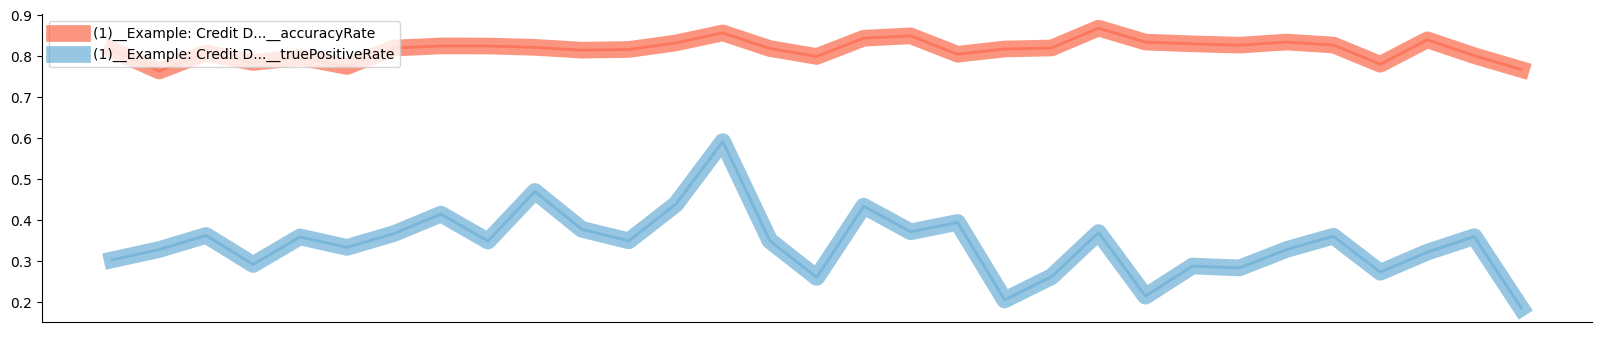

In [33]:
# visualize model performance metrics over time
arthur_model.viz.metric_series(["accuracyRate", "truePositiveRate"], time_resolution="day")

## Drift

### Get Drift Metrics

We get the amount of drift of recent model inferences from the baseline distribution of data in the reference set.

Note that drift queries communicate with a different API endpoint than other queries, so we indicate `query_type='drift'` as a parameter to the `ArthurModel.query()` method

In [36]:
# query drift of recent inferences from reference set
# we track drift in the 10-binned representation of the inputs
# to compare which feature's overall distribution is most drifted from the reference data
data_drift_query = {
    "properties": arthur_model.get_attribute_names(Stage.ModelPipelineInput),
    "num_bins": 10,
    "base": {
      "source": "reference",
    },
    "target": {
      "source": "inference",
    },
  "metric": "KLDivergence"
}
data_drift_response = arthur_model.query(data_drift_query, query_type='drift')

pd.DataFrame(data_drift_response).transpose()

,0
BILL_AMT1,0.771567
BILL_AMT2,0.868068
BILL_AMT3,1.101928
BILL_AMT4,0.807456
BILL_AMT5,0.669267
BILL_AMT6,0.609053
LIMIT_BAL,0.151564
PAY_0,0.218127
PAY_2,0.249253
PAY_3,0.291525


### Visualize Drift Over Time
The second drift method we use is `drift_series`, which visualizes the drift in our model's attributes at a given time resolution:

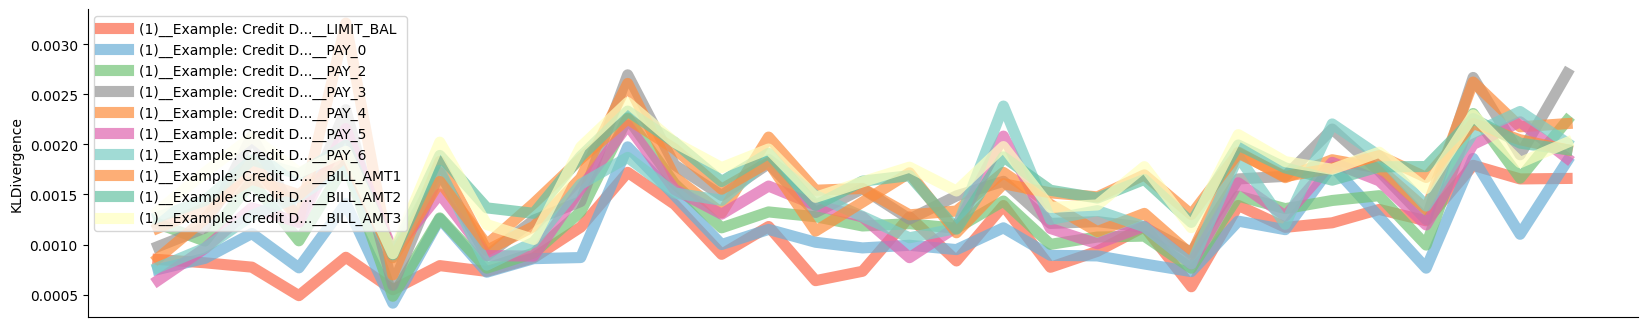

In [37]:
# visualize drift of recent inferences from reference set
arthur_model.viz.drift_series(
    ['LIMIT_BAL',
     'PAY_0',
     'PAY_2',
     'PAY_3',
     'PAY_4',
     'PAY_5',
     'PAY_6',
     'BILL_AMT1',
     'BILL_AMT2',
     'BILL_AMT3'], 
    drift_metric="KLDivergence", 
    time_resolution="day")

## Bias Monitoring

### Get Overall Bias Metrics

We get bias metrics for the model's sensitive attributes, which during onboarding were configured with the parameter `monitor_for_bias=True`

In [38]:
# query bias metrics for sensitive attributes
sensitive_attr_names = [attr.name for attr in arthur_model.get_attributes(stage=Stage.NonInputData)]

dem_parity = {}
confusion_matrices = {}
for sens_attr_name in sensitive_attr_names:
    dem_parity[sens_attr_name] = arthur_model.bias.metrics.demographic_parity(sens_attr_name)
    confusion_matrices[sens_attr_name] = arthur_model.bias.metrics.group_confusion_matrices(sens_attr_name)

In [40]:
dem_parity['MARRIAGE']

{0: 0.07692307692307693,
 1: 0.17302615790736742,
 2: 0.1528864453372806,
 3: 0.18681318681318682}

In [41]:
pd.DataFrame(confusion_matrices['SEX'])

,accuracy_rate,balanced_accuracy_rate,f1,false_negative_rate,false_positive_rate,precision,true_negative_rate,true_positive_rate
1,0.798168,0.637149,0.436871,0.665877,0.059826,0.630872,0.940174,0.334123
2,0.829196,0.651177,0.451190,0.641438,0.056208,0.608347,0.943792,0.358562


## Alerts

We configure an alert rule based on a metric and a threshold - when the metric crosses the threshold, the alert will be triggered and send a notification we can configure.

The rule below will notify us if overall accuracy rate drops below 60% in the future.

In [43]:
# Setup and alert rule to notify when the accuracy dips below 60%
arthur_model.create_alert_rule(
    metric_id=[x for x in arthur_model.get_metrics() if x.name=='Accuracy Rate'][0].id,
    bound="lower",
    threshold=0.6,
    severity="critical")

AlertRule(bound='lower', threshold=0.6, metric_id='8c6f26ba-9fbc-402a-a0a0-4ddb9b9e266f', severity='critical', name='Accuracy Rate lower bound', lookback_period=5, subsequent_alert_wait_time=0, enabled=True, id='0194bbbe-9caf-49e1-95d2-e5ce3ced15f4', metric_name='Accuracy Rate')

## Querying Enrichments


### Anomaly Scores

#### Get Anomaly Scores

We get the anomaly scores for a group of inferences, which measures how far these inferences stray from the baseline distribution of the model's reference set.

Note that anomaly scores, like all Enrichments, are a paid feature.

In [44]:
# query anomaly scores for inferences (as well as their their timestamp)
def anomaly_scores_for_inferences(model):
    query = {
      "select": [
          {
              "property": "anomaly_score",
          },
          {
              "property": "inference_timestamp"
          }
      ],
      "from": "enriched",
    }
    return pd.DataFrame(model.query(query))

In [ ]:
anomaly_score_result = anomaly_scores_for_inferences(arthur_model)

In [ ]:
anomaly_score_result